In [ ]:
import keras
import pandas as pd
import os
import gc
import sys
import time
from sys import stdout
from rnnmath import *
from utils import *
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from numpy.random import seed
seed(40)
tf.random.set_seed(40)

In [2]:
# Loads verb dataset extracting its subject index

def load_verb_dataset(fname):
    subj = []
    cnt = 0
    with open(fname) as f:
        for line in f:
            if cnt == 0:
                cnt += 1
                continue
            items = line.strip().split('\t')
            verb_idx = int(items[1])
            
            subj.append(verb_idx)
    return subj

In [3]:
# Define model hyperparameters:
vocab_size = 1000
train_size = 25000
dev_size = 5000
vocab = pd.read_table("/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/vocab.wiki.txt", header=None, sep="\s+", index_col=0, names=['count', 'freq'], )
num_to_word = dict(enumerate(vocab.index[:vocab_size]))
word_to_num = invert_dict(num_to_word)

In [4]:
# Load training sentences, define X_train and Y_train:
sents = load_np_dataset('/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/wiki-train.txt')
S_train = docs_to_indices(sents, word_to_num, 0, 0)
X_train, D_train = seqs_to_npXY(S_train)
X_train = X_train[:train_size]
Y_train = D_train[:train_size]

In [5]:
# Load validation sentences, define X_train and Y_train:
sents = load_np_dataset('/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/wiki-dev.txt')
S_dev = docs_to_indices(sents, word_to_num, 0, 0)
X_dev, D_dev = seqs_to_npXY(S_dev)
X_dev = X_dev[:dev_size]
Y_dev = D_dev[:dev_size]

In [6]:
# returns longest sentence length to do zero-padding
ant=0
for i in X_train:
    if len(i)> ant:
        ant=len(i)

In [7]:
# Do padding
max_length = ant
padded_X = pad_sequences(X_train, maxlen=max_length, padding='post')
padded_X_dev = pad_sequences(X_dev, maxlen=max_length, padding='post')

In [8]:
# Define RNN + final sigmoid layer in Keras
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 64, input_length=ant))
model.add(keras.layers.SimpleRNN(1,return_sequences=True,name='rnn'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile('adam', 'binary_crossentropy',metrics=['accuracy'])
model.summary()

2022-02-16 10:36:48.200637: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-16 10:36:48.455139: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3199980000 Hz
2022-02-16 10:36:48.455698: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a2d10ddbe0 executing computations on platform Host. Devices:
2022-02-16 10:36:48.455737: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2022-02-16 10:36:48.456378: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Model: "sequential_1"
_____________________________________

In [9]:
# Train the model:

mod = model.fit(padded_X, Y_train, epochs=10, verbose=1,validation_data=(padded_X_dev,Y_dev))

Train on 25000 samples, validate on 1000 samples
Epoch 1/10
25000/25000 [==============================] - 23s 909us/step - loss: 0.4228 - accuracy: 0.8149 - val_loss: 0.3900 - val_accuracy: 0.8290
Epoch 2/10
25000/25000 [==============================] - 19s 754us/step - loss: 0.3630 - accuracy: 0.8524 - val_loss: 0.3736 - val_accuracy: 0.8500
Epoch 3/10
25000/25000 [==============================] - 18s 735us/step - loss: 0.3502 - accuracy: 0.8632 - val_loss: 0.3739 - val_accuracy: 0.8530
Epoch 4/10
25000/25000 [==============================] - 19s 743us/step - loss: 0.3455 - accuracy: 0.8646 - val_loss: 0.3662 - val_accuracy: 0.8520
Epoch 5/10
25000/25000 [==============================] - 19s 755us/step - loss: 0.3385 - accuracy: 0.8661 - val_loss: 0.3594 - val_accuracy: 0.8560
Epoch 6/10
25000/25000 [==============================] - 19s 742us/step - loss: 0.3341 - accuracy: 0.8724 - val_loss: 0.3629 - val_accuracy: 0.8570
Epoch 7/10
25000/25000 [==============================] -

In [10]:
test_size = 10000

# Load Test dataset:

sents = load_np_dataset('/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/wiki-test.txt')
S_test = docs_to_indices(sents, word_to_num, 0, 0)
X_test, D_test = seqs_to_npXY(S_test)
X_test = X_test[:test_size]
Y_test = D_test[:test_size]


padded_X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [11]:
# extracts activations from RNN output sequence on test set and multiplies it by the weights
# from the last layer to get the input signal to the activation function.

active_layer = keras.Model(inputs=model.input, outputs = model.layers[2].output)

active_layer = active_layer.predict(padded_X_test, steps = 1) # predict_generator is deprecated

w=model.layers[3].get_weights()[0].flatten()

s=np.multiply(active_layer,w)
ans=np.zeros(len(X_test))

# Identifies which index from the output sequence gives the highest (for plural verbs) and lowest (for singular verbs) signal

for i, sent in enumerate(X_test):
    if D_test[i][0] == 1:
        m=np.argmax(s[i][:len(sent)])
    else:
        m=np.argmin(s[i][:len(sent)])
    ans[i]=int(m)

In [12]:
# Get ground truth subject indexes from test

verbs = np.array(load_verb_dataset('/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/wiki-test.txt'))

In [13]:
# Percentage of correctly identified subjects based on strongest signals.

res=(ans==verbs)
print(np.mean(res))

In [15]:
# Additional function to calculate top n signals and find if the subject is identified there

lens=np.zeros(len(X_test))
for i,j in enumerate(X_test):
    lens[i]=len(j)

def get_n_best(n,X_test,verbs):

    ans2=np.zeros(len(X_test))
    for i, sent in enumerate(X_test):
        if D_test[i][0] == 1:
            m=np.argsort(s[i][:len(sent)])[-n:] #take out colon for single index - after n
        else:
            m=np.argsort(s[i][:len(sent)])[:n] #take out colon for single index - before n
        if verbs[i] in m:
            ans2[i]=1
    return np.mean(ans2), ans2

In [19]:
# subject accuracy *when first argument of get_n_best function is 1, this is the same as the subject accuracy calculation two cells above

prop, subj_ind=get_n_best(1,X_test,verbs)
print(np.mean(prop))

0.444


In [20]:
# Predict to get model test accuracy
predictions=(model.predict(padded_X_test)>0.5)
corrects=(predictions==D_test)

In [21]:
#test accuracy
print(np.mean(corrects))

0.87375

In [23]:
# What if random selection of subject? Estimates subject identification by randomly selecting subject and see if by chance it manages to idenfify it correctly

lens=np.zeros(len(X_test))
for i,j in enumerate(X_test):
    lens[i]=len(j)

res_ran=np.zeros(len(verbs))
for i,v in enumerate(lens):
    res_ran[i]=np.random.randint(0,v)
print(np.mean(ans==res_ran))

0.27775


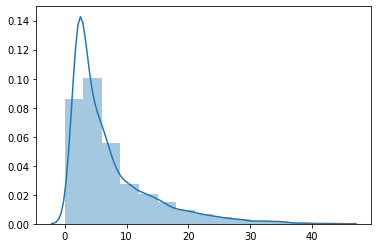

In [21]:
# Distribution of sentences length

import matplotlib.pyplot as plt
import seaborn as sns
num_bins=np.arange(0,45,3)
sns.distplot(lens,bins=num_bins)
plt.show()

In [22]:
# Percentage of sentences less or equal than m words
print(np.mean(lens<=1))

0.02575

In [10]:
# Load subjects indexes from train and test sets
subj = np.array(load_verb_dataset('/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/wiki-train.txt'))
subj_test = np.array(load_verb_dataset('/afs/inf.ed.ac.uk/user/s22/s2209091/nlu/data/wiki-test.txt'))

In [11]:
# Delete sentences with 1 word - Needed since we will perform the drop column feature importance method, dropping one word

X_train_drop = X_train[:]
Y_train_drop = Y_train[:]
ind_to_drop = np.zeros(len(X_train))
for i,j in enumerate(X_train_drop):
    if len(j)==1:
        ind_to_drop[i] = i

X_train_drop=np.delete(X_train_drop,ind_to_drop)
Y_train_drop=np.delete(Y_train_drop,ind_to_drop)
subj=np.delete(subj,ind_to_drop)

X_test_drop = X_test[:]
Y_test_drop = Y_test[:]
ind_to_drop = np.zeros(len(X_test))

for i,j in enumerate(X_test_drop):
    if len(j)==1:
        ind_to_drop[i] = i

X_test_drop=np.delete(X_test_drop,ind_to_drop)
Y_test_drop=np.delete(Y_test_drop,ind_to_drop)

subj_test=np.delete(subj_test,ind_to_drop)

In [12]:
# Padding sentences to max length found earlier

max_length = 46
padded_X_drop = pad_sequences(X_train_drop, maxlen=max_length, padding='post')
padded_X_test_drop = pad_sequences(X_test_drop, maxlen=max_length, padding='post')

In [13]:
# Deletion of subject word for each sentence for both training and test set
new_padded_X_drop=[]
for i,sen in enumerate(padded_X_drop):
    new_padded_X_drop.append(np.delete(sen,subj[i]))


new_padded_X_test_drop=[]
for i,sen in enumerate(padded_X_test_drop):
    new_padded_X_test_drop.append(np.delete(sen,subj_test[i]))

In [16]:
# Simulations for first feature importance experiment> dropping the subject

sims=10

for i in range(sims):
    seed(42+i)

    tf.random.set_seed(42+i)
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 64, input_length=45))
    model.add(keras.layers.SimpleRNN(1,return_sequences=True,name='rnn'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy',metrics=['accuracy'])


    model.fit(np.array(new_padded_X_drop), Y_train_drop, epochs=10, verbose=1)
    predictions=(model.predict(np.array(new_padded_X_test_drop))>0.5)

    corrects=(predictions==Y_test_drop)
    print('Simulation: ',i,' -- Test accuracy: ',round(np.mean(corrects),4))

Epoch 1/10
24353/24353 [==============================] - 16s 677us/step - loss: 0.5078 - accuracy: 0.7710
Epoch 2/10
24353/24353 [==============================] - 16s 642us/step - loss: 0.4654 - accuracy: 0.8002
Epoch 3/10
24353/24353 [==============================] - 15s 626us/step - loss: 0.4545 - accuracy: 0.8085
Epoch 4/10
24353/24353 [==============================] - 16s 650us/step - loss: 0.4494 - accuracy: 0.8139
Epoch 5/10
24353/24353 [==============================] - 16s 643us/step - loss: 0.4461 - accuracy: 0.8165
Epoch 6/10
24353/24353 [==============================] - 16s 646us/step - loss: 0.4468 - accuracy: 0.8164
Epoch 7/10
24353/24353 [==============================] - 17s 680us/step - loss: 0.4418 - accuracy: 0.8192
Epoch 8/10
24353/24353 [==============================] - 16s 645us/step - loss: 0.4394 - accuracy: 0.8206
Epoch 9/10
24353/24353 [==============================] - 17s 708us/step - loss: 0.4376 - accuracy: 0.8224
Epoch 10/10
24353/24353 [============

In [14]:
# Simulations to drop word randomly for words different than subject
sims=10
acc = np.zeros(sims)

sent_len_tr = np.zeros(len(X_train_drop))
for i,sent in enumerate(X_train_drop):
    sent_len_tr[i]=len(sent)

sent_len_te = np.zeros(len(X_test_drop))
for i,sent in enumerate(X_test_drop):
    sent_len_te[i]=len(sent)

new_padded_X_drop=[]

for i,sen in enumerate(padded_X_drop):
    indx=np.arange(0,sent_len_tr[i])
    indx = np.random.choice(indx[indx != subj[i]])
    new_padded_X_drop.append(np.delete(sen,indx))

new_padded_X_test_drop=[]
for i,sen in enumerate(padded_X_test_drop):
    indx=np.arange(0,sent_len_te[i])
    indx = np.random.choice(indx[indx != subj_test[i]])
    new_padded_X_test_drop.append(np.delete(sen,indx))

for s in range(sims):
    seed(42+s)

    tf.random.set_seed(42+s)
    print('Starting with simulation ',s)
    #new_padded_X_drop=[]


    keras.backend.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, 64, input_length=45))
    model.add(keras.layers.SimpleRNN(1,return_sequences=True,name='rnn'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1,activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy',metrics=['accuracy'])

    model.fit(np.array(new_padded_X_drop), Y_train_drop, epochs=10, verbose=1)

    predictions=(model.predict(np.array(new_padded_X_test_drop))>0.5)
    corrects=(predictions==Y_test_drop)
    acc[s]=np.mean(corrects)
    print('Simulation: ',s,' -- Test accuracy: ',round(acc[s],4))    

Starting with simulation  9
2022-02-14 15:34:24.842873: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-14 15:34:24.870844: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3199980000 Hz
2022-02-14 15:34:24.871084: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e0e7d95fe0 executing computations on platform Host. Devices:
2022-02-14 15:34:24.871099: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2022-02-14 15:34:24.873270: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Epoch 1/10
24353/24353 [=======